# Homework 1 Group O
Florian Ulbricht 485080

Martin Hahn 484109

Mattis Rosenkranz 487615

David Andrés Mancera Carrillo 487621

In [1]:
import numpy as np
import soundfile as sf
from matplotlib import pyplot as plt
import soundfile as fs
import timeit
import cmath

In [2]:
def generate_sin(n, f, fs):
    w0 = f / fs
    x = np.arange(n)
    return np.sin(2 * np.pi * w0 * x)

### 1 Import and display audio files


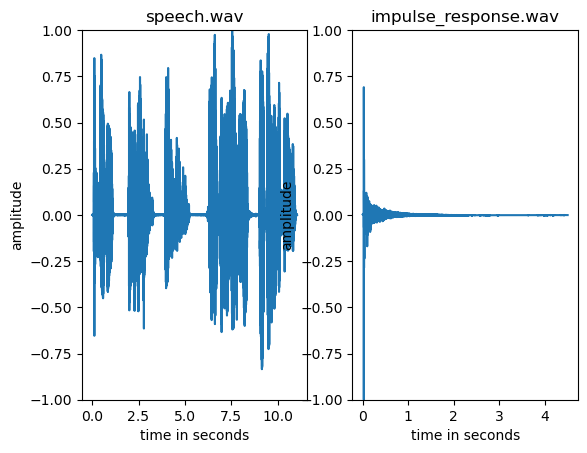

In [3]:
figure, axes_list = plt.subplots(ncols=2)
file_names = ['speech.wav', 'impulse_response.wav']

for file, axes in zip(file_names, axes_list):
    data, sample_rate = sf.read(file, always_2d=True)
    first_channel = np.rot90(data)[0]
    first_channel_normalized = first_channel / np.max(np.abs(first_channel))

    x = np.arange(0, len(first_channel)) / sample_rate

    axes.set_title(file)
    axes.set_ylim([-1, 1])
    axes.set_xlabel('time in seconds')
    axes.set_ylabel('amplitude')
    axes.plot(x, first_channel_normalized)



### 2 System properties

### 3 Convolution

a) Make the system causal and determine the impulse response h[n]


y[n-2] = 0,2 * {x[n] + x[n-1] + x[n-2] + x[n-3] + x[n-4]}

h[n] = [... 0.2, 0.2, 0.2, 0.2, 0.2 ...]

b) Implement a function convolve(a, b) that convolves the signals a and b without using third
party function such as numpy.convolve. Verify that the output for a=[1, -1] and b=[2, 0, 0,
1] is a=[2, -2, 0, 1, -1].


In [4]:
def convolve(a, b):
    length = len(a) + len(b) - 1
    return [
        sum([
            a[k] * b[n - k]
            for k in range(0, n + 1)
            if k < len(a) and n - k < len(b)
        ])
        for n in range(length)
    ]

In [5]:
a = [1, -1]
b = [2, 0, 0, 1]
result = convolve(a, b)
expected_result = [2, -2, 0, 1, -1]
np.testing.assert_equal(result, expected_result)

 c) Generate sine signals x1[n] and x2[n] with a duration of 16 samples, a sampling rate of 16 kHz, and frequencies of 1 and 4 kHz. Convolve the signals with the impulse response from a) (use numpy.convolve if you did not finish b), and plot the results.

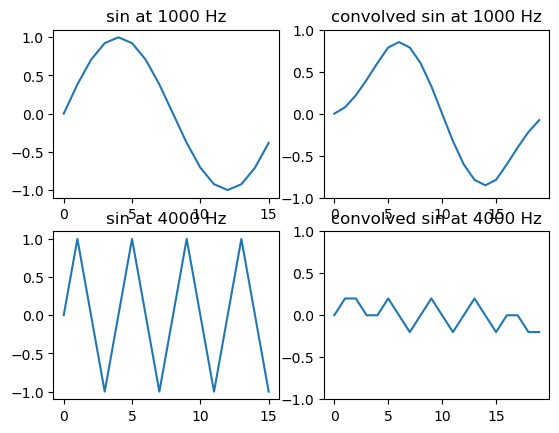

In [6]:
h = [0.2] * 5

n = 16
fs = 16000

frequencies = [1000, 4000]
figure, axes_list = plt.subplots(2, 2)

for f, [axis_1, axis_2] in zip(frequencies, axes_list):
    sin = generate_sin(n, f, fs)
    convolved_sin = convolve(sin, h)

    axis_1.set_title(f'sin at {f} Hz')
    axis_1.set_ybound(-1, 1)
    axis_1.plot(sin)
    axis_2.set_title(f'convolved sin at {f} Hz')
    axis_2.plot(convolved_sin)
    axis_2.set_ybound(-1, 1)


d) Describe the behavior of the system. How does it affect the time signals?

- time signal becomes 4 samples longer
- dampens especially higher frequencies (4 kHz more than 1 kHz) --> acts like low pass / high cut (smoothes the signal)
- warpes the time course, thus introducing new frequencies
- acts similar to a 'blur' filter in imageprocessing (moving average)
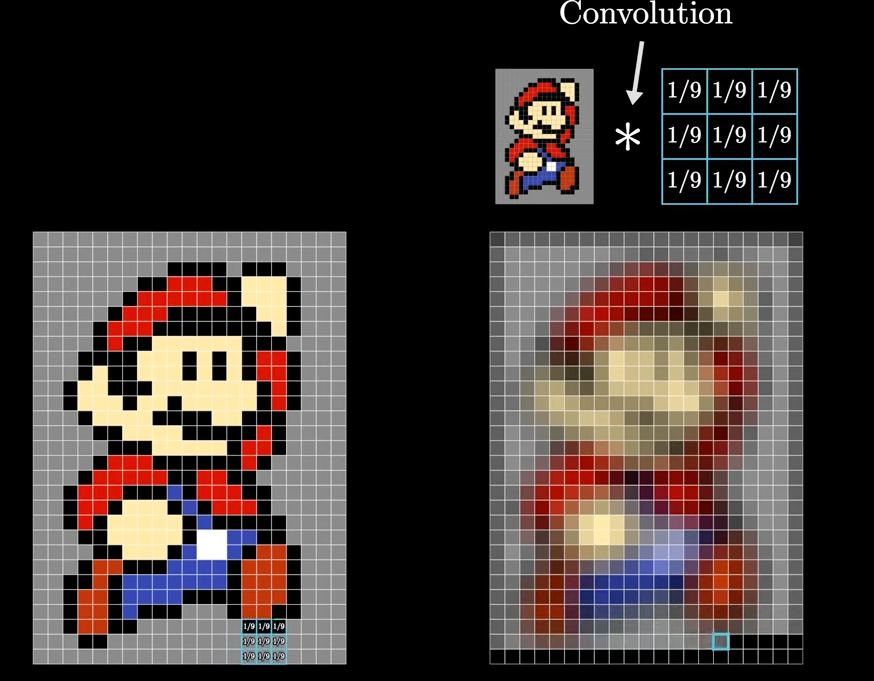

e) Show the following by calculating and plotting the corresponding signals: x1[n]∗h[n] = h[n]∗x1[n]
and (x1[n] ∗ h[n]) + (x2[n] ∗ h[n]) = (x1[n] + x2[n]) ∗ h[n].

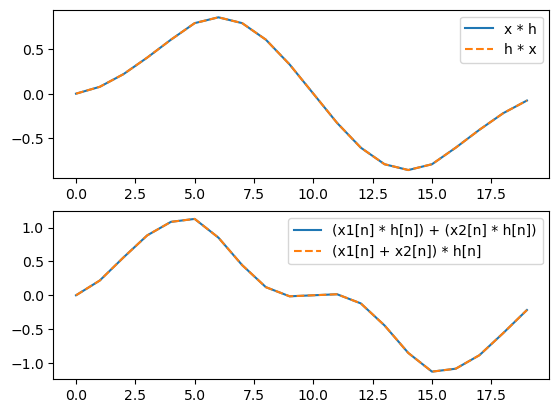

In [7]:
figure, [axes_1, axes_2] = plt.subplots(2)

x1 = generate_sin(16, 1000, 16000)
x2 = generate_sin(16, 2000, 16000)

axes_1.plot(convolve(x1, h), label='x * h')
axes_1.plot(convolve(h, x1), label='h * x', linestyle='dashed')
axes_1.legend()

axes_2.plot(
    np.add(convolve(x1, h), convolve(x2, h)),
    label='(x1[n] * h[n]) + (x2[n] * h[n])'
)
axes_2.plot(
    convolve(np.add(x1, x2), h),
    label='(x1[n] + x2[n]) * h[n]',
    linestyle='dashed'
)
axes_2.legend()

### 4. Discrete Fourier Transform Implementation


a) Check if the results are identical using numpy.testing.assert_allclose (This should work with
the default parameters for rtol and atol).


In [8]:
def rdft(x, fs):
    N = len(x)
    length = N // 2 + 1
    n = np.arange(N)
    f = fs * n[0:length] / N
    f_transposed = f.reshape((length, 1))
    matrix = np.exp(-2j * np.pi * f_transposed * n / fs)
    X = np.dot(matrix, x)
    return X, f

In [9]:
N = [1024, 1025, 1026, 1027, 4096, 8192]

# result tests
for n in N:
    x = np.random.rand(n) * 2 - 1

    X, frequencies = rdft(x, n)
    expected_result = np.fft.rfft(x)
    expected_frequencies = np.fft.rfftfreq(n, 1 / n)
    np.testing.assert_equal(frequencies, expected_frequencies)
    np.testing.assert_allclose(X, expected_result)

b) Compare the computation times with timeit.timeit using five repetitions (number=5). Hint:
You have to use the parameter globals to pass the required variables and function to timeit, e.g.,
globals={"rdft": rdft, "x": x, "fs": fs}.


In [10]:
repetitions = 5
print(
    f'{"n":9}'
    f'{"rdft average time (ms)":27}'
    f'{"numpy rfft average time (ms)":27}'
)
for n in N:
    x = np.random.rand(n) * 2 - 1
    seconds_taken_rdft = timeit.timeit(
        'rdft(x, n)',
        number=repetitions,
        globals={"rdft": rdft, "x": x, "n": n}
    )
    seconds_taken_rfft = timeit.timeit(
        'np.fft.rfft(x), np.fft.rfftfreq(n, 1 / n)',
        setup='import numpy as np',
        number=repetitions,
        globals={"x": x, "n": n}
    )
    print(
        f'{n:<9}'
        f'{(seconds_taken_rdft / repetitions * 1000):<27.5f}'
        f'{(seconds_taken_rfft / repetitions * 1000):<27.5f}'
    )

n        rdft average time (ms)     numpy rfft average time (ms)
1024     38.07598                   0.02850                    
1025     36.70330                   0.03722                    
1026     36.73406                   0.03146                    
1027     36.81648                   0.05662                    
4096     594.40618                  0.06308                    
8192     2293.25104                 0.08194                    


### 5 Temporal aliasing


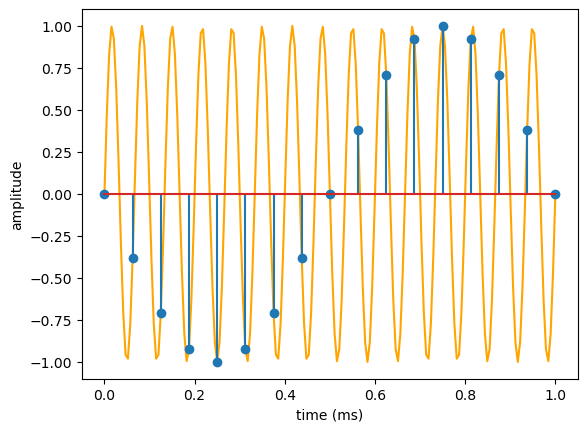

In [11]:
f = 15_000

figure, axes = plt.subplots()
axes.set_xlabel('time (ms)')
axes.set_ylabel('amplitude')

for fs, plot_function in zip(
    [192_000, 16_000],
    [lambda x, y: axes.plot(x, y, color='orange'),
     lambda x, y: axes.stem(x, y)]
):
    length = fs // 1000 + 1
    x = np.arange(0, length) / fs * 1000
    y = generate_sin(length, f, fs)
    plot_function(x, y)

Since the 15 kHz signal is above half the sampling frequency (16 kHz), the sampling theorem (f < fs/2) is not observed. This results in aliasing. This means incorrect sampling and becomes clear in the diagram shown. The resulting frequency is fs - f = 16 kHz - 15 kHz = 1 kHz.

simply explained: The signal moves faster than it can be sampled. The excerpted sampling creates a new signal, which does not correspond to the actual frequency.